In [23]:
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.linalg import eig, solve

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

In [3]:
datapath = Path().cwd().parent / "data"
db = h5py.File(datapath / "4_500_36_9.h5", "r")

print("Attributes of database:")
for key in db.attrs:
    print(f"{key}: {db.attrs[key]}")

print("\nData in the database:")
for key in db:
    print(f"{key}: {db[key].shape}")

Attributes of database:
grid_size: [5.00e-07 1.25e-07 3.00e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [36  9  1]
seed: 0
t_per_step: 4e-12
t_steps: 500

Data in the database:
field: (4, 3)
sequence: (4, 500, 36, 9, 3)


# ROM for timestepping for a given $\mathbf{H}_{ext}$

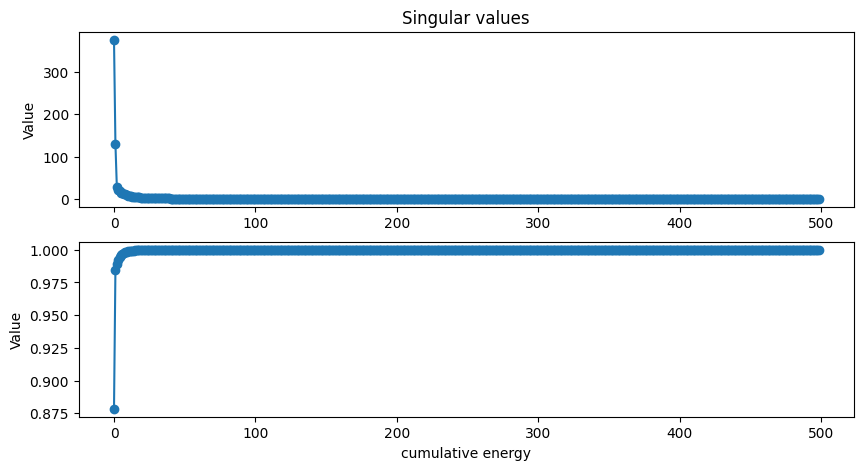

In [16]:
X = db["sequence"][0]
data_dim = X.shape[1:]  # (x_dim, y_dim, magnetization components (3))

X_flat = X.reshape(X.shape[0], -1)  # flatten data to (t_steps, x_dim * y_dim * 3)

X1 = X_flat[:-1, :]   
X2 = X_flat[1:, :]

#SVD
U, S, VT = np.linalg.svd(X1, full_matrices=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(S, "o-")
axs[0].set(title="Singular values", ylabel="Value")

energy = np.cumsum(S ** 2 / np.sum(S ** 2))
axs[1].plot(energy, "o-")
axs[1].set(xlabel="cumulative energy", ylabel="Value")
plt.show()

In [21]:
#trunction
r = np.argmax(energy > 0.99)  # find the index where cumulative energy exceeds 0.99
print(f"number of modes: {r}")
U_r, S_r, VT_r = U[:, :r], S[:r], VT[:r, :]

number of modes: 3


In [ ]:
A_tilde = U_r.T @ X2 @ VT_r.T * (1/S_r)
Lambdas, W = eig(A_tilde)

Phi = (X2 @ VT_r.T * (1 / S_r)) @ W

#forecast x_k = Phi @ Lambdas^(k-1) @ b, wher b = Phi @ x_1
x1_tilde = S_r * VT_r[:,0]
b = solve(W * Lambdas, x1_tilde)

def forecast(k0, kf, Phi, Lambdas, b) -> np.ndarray:
    x_forecast = np.zeros((kf - k0 + 1, Phi.shape[0]))

    for i in range(kf - k0 + 1):
        x_forecast[i,:] = np.real((Phi * Lambdas ** (i + k0 - 1)) @ b)

    return x_forecast.T

X_pred = forecast(1, 151, Phi, Lambdas, b)
X_forecast = forecast(152, 152 + 150, Phi, Lambdas, b)